## Trip advisor hotel review predictions

Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
This dataset consist of 20k reviews crawled from Tripadvisor. 

**The objective of this project is to build a classifier that predicts customer reviews as either positive or negative**

In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#other imports
import re
import random
from contractions import contractions_dict 
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
df.shape

(20491, 2)

In [4]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [6]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Exploratory Data analysis

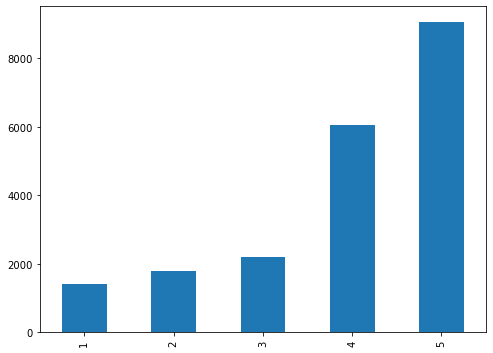

In [7]:
df['Rating'].value_counts(ascending = True).plot(kind = 'bar', figsize = (8, 6))

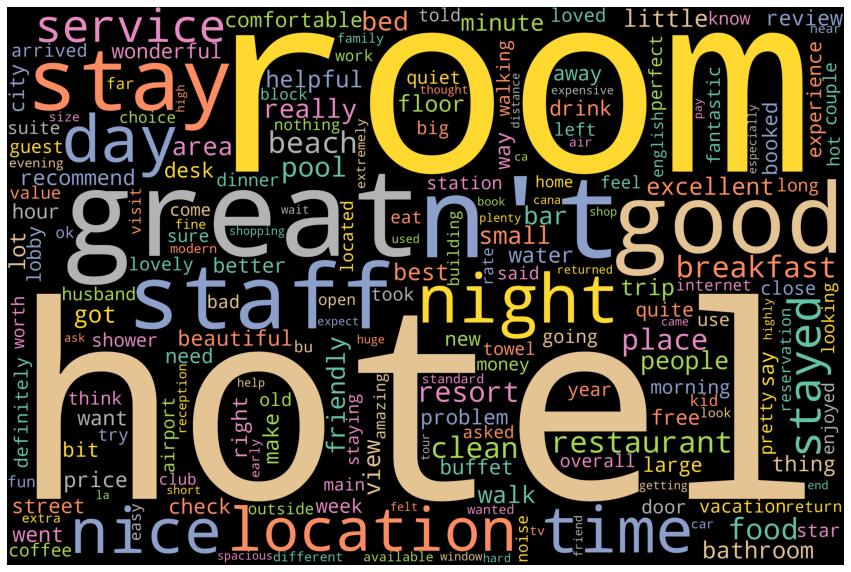

In [8]:
word_cloud = WordCloud(background_color = 'black', width=3000, height = 2000, stopwords=STOPWORDS, colormap = 'Set2', collocations = False).generate(' '.join(df['Review']))
plt.figure(figsize=(15, 11))
# Display image
plt.imshow(word_cloud) 
# No axis details
plt.axis("off")
plt.show()

In [9]:
df['Review_length'] = df['Review'].str.len()

In [10]:
df['Review'] = df['Review'].str.strip()
df['num_of_words_in_review'] = df['Review'].str.split().apply(len)

#### How does rating relate to number of words used in review? 

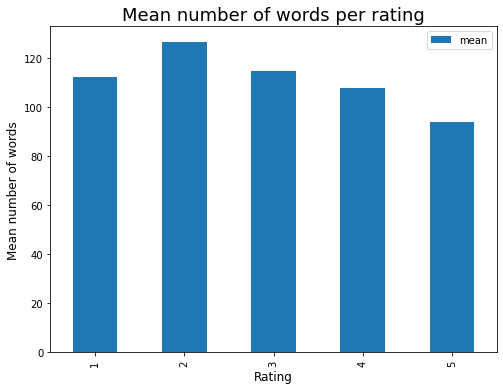

In [11]:
df.groupby(['Rating'])['num_of_words_in_review'].agg(['mean']).plot(kind = 'bar', figsize = (8, 6))
plt.xlabel('Rating', size = 12)
plt.ylabel('Mean number of words', size = 12)
plt.title('Mean number of words per rating', size = 18)
plt.show()

#### Rating 2 has the highest average number of words while rating 5 has the lowest average number of words. This makes sense since remarkable comments tend to be more precise. 

#### What is the distribution of the character lenght of each label rating 

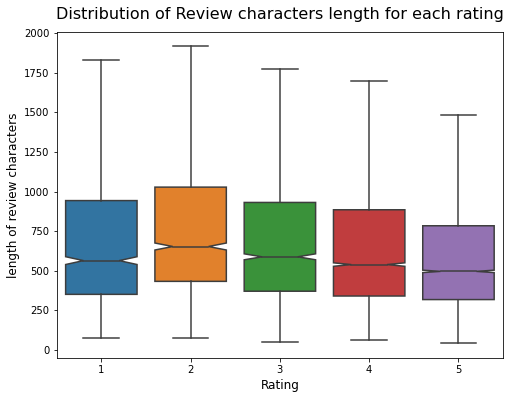

In [12]:
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'Rating', y = 'Review_length', data = df, showfliers = False, notch=True)
plt.xlabel('Rating', size = 12)
plt.ylabel('length of review characters', size = 12)
plt.title('Distribution of Review characters length for each rating', size = 16, y = 1.02)
plt.show()

#### The median length of review character for rating 2 is the highest while the median length of review 5 is the lowest as shown in this figure. This value is consistent with the average number of words shown in the figure above. Alos, the median length of all 5 ratings are relative similar

#### Inspect the review for each Rating

In [13]:
for rating in range(df['Rating'].min(), df['Rating'].max() + 1):
    print("This is a random review for rating equal {}".format(rating))
    print("=" * 30)
    print(df[df['Rating'] == rating].loc[random.sample(list(df[df['Rating'] == rating].index), 1)[0], 'Review'])
    print("=" * 30)
    print('\n')

This is a random review for rating equal 1
horrible service terrible, ordered simply coffee twice room service time hours came reminder calls desk, menu dragon fly awful, finally order simple food child menu cost 50.00, non-smoking hotel great smoke not told case making reservation, music pool area inundated room 2 non-stop, walls paper staff unresponsive robes rooms non-existent, paid 1000.00 excruciating night stay, ca n't food service privacy room not hotel, honestly worst place stayed,


This is a random review for rating equal 2
n't, planning visit resort n't money change resorts.my husband not high maintenance, arrived resort saturday 7 july, paid way money inclusive trip 1500 expected better service, arrival room vip suite bedpost broken head bed, called 5 times came began fixing door patio nothing wrong, didn__Ç_é_ understand desk told obviously didn__Ç_é___Ç understand said understood complaint, called desk ask person fixing door didn__Ç_é_ door, eventually doing sign language

#### After careful inspection of the random review for each rating just like above, review 1 and 2 tend to be negative, and review 3, 4, and 5 tend to be positive. Therefore, we will create a class label feature from this rating column. 

In [14]:
# Create label class
def Labelfunc(rating):
    if rating >= 3:
        return 'Positive'
    else:
        return 'Negative'

In [15]:
df['label'] = df['Rating'].apply(lambda x: Labelfunc(x))

#### What are the ratings and their respective counts?

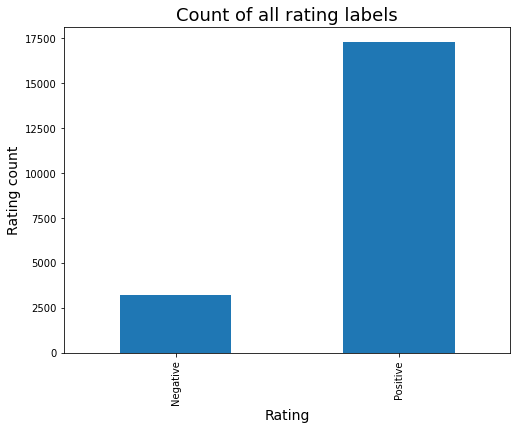

In [16]:
df['label'].value_counts().loc[['Negative', 'Positive']].plot(kind = 'bar', figsize = (8, 6))
plt.xlabel('Rating', size = 14)
plt.ylabel('Rating count', size = 14)
plt.title('Count of all rating labels', size = 18)
plt.show()

#### The rating = 5 has majority of the counts

#### What is the relationship between review length, number of words in review, grouped by lables?

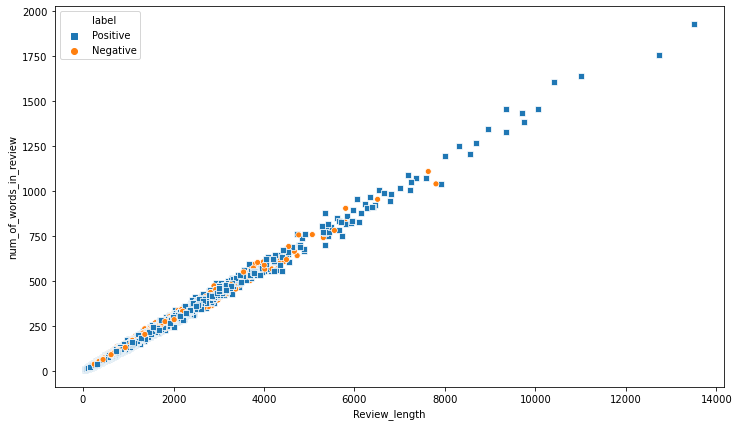

In [17]:
plt.figure(figsize = (12, 7))
markers = {"Positive": "s", "Negative" : 'o'}
sns.scatterplot(x = 'Review_length', y = 'num_of_words_in_review', data = df, hue ='label', style = 'label', markers = markers)
plt.show()

#### We notice a strong linear relationship btw length of characters and num of words in review. Also, majority of the reviews with more characters or words seem to be of positive labels

In [18]:
df.head()

,Review,Rating,Review_length,num_of_words_in_review,label
0,nice hotel expensive parking got good deal sta...,4,593,87,Positive
1,ok nothing special charge diamond member hilto...,2,1689,250,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217,Positive
3,"unique, great stay, wonderful time hotel monac...",5,600,89,Positive
4,"great stay great stay, went seahawk game aweso...",5,1281,191,Positive


### Data Cleaning and Preprocessing

In [19]:
#search the number of rows with any type of url
print('Number of rows with urls is {}'.format(df[df['Review'].str.contains(r'http\S+|\.com|www\.[A-Za-z]+', regex = True)].shape[0]))
print(df[df['Review'].str.contains(r'http\S+|[A-Za-z]+\.com|www\.+', regex = True)].loc[204, 'Review'])

Number of rows with urls is 351
posh hotel husband stayed hilton seattle september 2003 night really liked, stayed queen room bed, bed linens wall paper furniture bathroom really nice, nice view, centrally located, reserved room hotwire.com room 100,


#### Removing URL

In [20]:
#functions to remove urls
def clean_url(text):
    return re.sub(r'http\S+|[A-Za-z]+\.com|www\.+', '', text)

In [21]:
df['Review'] = df['Review'].apply(lambda x: clean_url(x))

#### Lower Casing

In [22]:
#apply lambda expression for lower casing
df['Review'] = df['Review'].apply(lambda x: x.lower())

#### Dealing with contractions

We will expand contractions in our text which will allow for them to be tokenize together. In other words, "I' ve" = "I have" instead of "I", "have". 

In [23]:
#find some contractions in text
def known_contractions(text):
    known = []
    for contract in contractions_dict:
        if contract in text:
            known.append(contract)
    return known

In [24]:
print("The contraction in the Review text are: \n{}".format(known_contractions(' '.join(df["Review"]))))

The contraction in the Review text are: 
["can't", "couldn't", "didn't", "don't", "haven't", "he's", "isn't", "it's", "o'clock", "she's", "shouldn't", "that's", "wasn't", "we've", "won't", "wouldn't", "y'all", 'jan.', 'feb.', 'mar.', 'aug.', 'sep.', 'oct.', 'nov.', 'dec.']


In [25]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [26]:
df['Review'] = df['Review'].apply(lambda x: clean_contractions(x, contractions_dict))

#### Remove Punctuations

In [27]:
df['Review'] = df['Review'].apply(lambda x: x.translate(str.maketrans('', '', punctuation)))

In [28]:
#check if the stop word "." in string
df[df['Review'].str.contains(r"\.")]

,Review,Rating,Review_length,num_of_words_in_review,label


#### Tokenization

In [29]:
def tokenize_text(text):
    tokens = re.split('\W+', text) #W+ means either a word character or a dash(-) can go there
    return tokens

df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_text(x))

In [30]:
df['Review_tokenized'].head()

0    [nice, hotel, expensive, parking, got, good, d...
1    [ok, nothing, special, charge, diamond, member...
2    [nice, rooms, not, 4, experience, hotel, monac...
3    [unique, great, stay, wonderful, time, hotel, ...
4    [great, stay, great, stay, went, seahawk, game...
Name: Review_tokenized, dtype: object

#### Removal of stopwords

In [31]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [32]:
stop_words = stopwords.words('english')

In [33]:
def remove_stopwords(token_text):
    
    """ function to remove stopwords from text"""
    return " ".join([word for word in token_text if word not in stop_words])

In [34]:
df['Review_tokenized_with_no_stop_words'] = df['Review_tokenized'].apply(lambda x: remove_stopwords(x))

In [35]:
df['Review_tokenized_with_no_stop_words'].head(2)

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
Name: Review_tokenized_with_no_stop_words, dtype: object

In [36]:
df.head()

,Review,Rating,Review_length,num_of_words_in_review,label,Review_tokenized,Review_tokenized_with_no_stop_words
0,nice hotel expensive parking got good deal sta...,4,593,87,Positive,"[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,1689,250,Negative,"[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...
2,nice rooms not 4 experience hotel monaco seatt...,3,1427,217,Positive,"[nice, rooms, not, 4, experience, hotel, monac...",nice rooms 4 experience hotel monaco seattle g...
3,unique great stay wonderful time hotel monaco ...,5,600,89,Positive,"[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,5,1281,191,Positive,"[great, stay, great, stay, went, seahawk, game...",great stay great stay went seahawk game awesom...


### Train Test Split

In [37]:
df_new = df.copy()

In [38]:
X = df_new['Review_tokenized_with_no_stop_words']
y = df_new['label']

In [39]:
#creating training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=1)

#creating validation set from training set 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [40]:
X_train.shape

(12294,)

### Vectorizing of text data using CountVectorizer

#### Conversion of text feature into bag of words (bow)/CountVectorizer. In this preprocessing step, text will be converted to numeric forms so that machine learning algorithms can understand the data. 

In [41]:
count_vec = CountVectorizer(max_df = 0.98)
count_train = count_vec.fit_transform(X_train.values)
count_val = count_vec.transform(X_val.values)

### Model training and Evaluation

KNeighborsClassifier


****Accuracy****
Accuracy: 0.8530990727183992

****Confusion matrix****


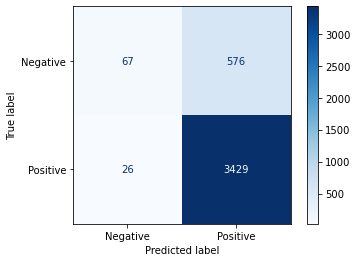

SVC


****Accuracy****
Accuracy: 0.9184968277208394

****Confusion matrix****


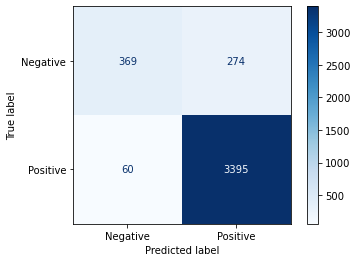

LinearSVC


****Accuracy****
Accuracy: 0.9187408491947291

****Confusion matrix****


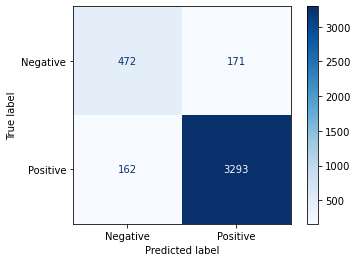

MultinomialNB


****Accuracy****
Accuracy: 0.9184968277208394

****Confusion matrix****


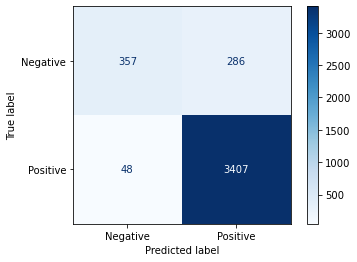

DecisionTreeClassifier


****Accuracy****
Accuracy: 0.8560273304050756

****Confusion matrix****


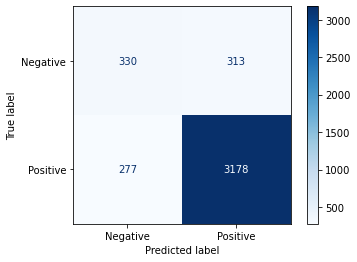

RandomForestClassifier


****Accuracy****
Accuracy: 0.8689604685212299

****Confusion matrix****


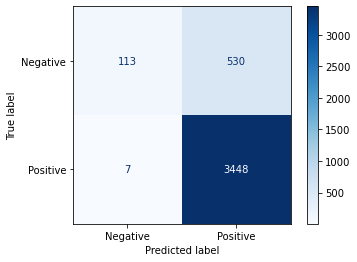

In [42]:
random_state = 1
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", random_state = random_state),
    LinearSVC(random_state = random_state),
    MultinomialNB(),
    DecisionTreeClassifier(random_state = random_state),
    RandomForestClassifier(random_state = random_state),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'True Positive', 'True Negative']
log = pd.DataFrame(columns=log_cols)

i = 0
for clf in classifiers:
    i += 1
    clf.fit(count_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)
    print('\n')
    print('****Accuracy****')
    y_pred = clf.predict(count_val)
    acc = accuracy_score(y_val, y_pred)
    tn = confusion_matrix(y_pred, y_val)[0, 0]
    tp = confusion_matrix(y_pred, y_val)[1, 1]
    print("Accuracy: {}\n".format(acc))
    print('****Confusion matrix****')
    ax = plot_confusion_matrix(clf, count_val, y_val, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
    plt.show()
    log_entry = pd.DataFrame([[name, acc*100, tp, tn]], columns=log_cols, index = [i]) #appending a new row
    log = log.append(log_entry)
print("="*30) 


#### We achieved accuracy as high as 91 percent. However, when dealing with an imbalance datasets, confusion matrix helps to show how the classifier performs with predicting negative classes as well. For this reason, Linear SVC did perform well in this case. It predicted the highes number of True Negative compared to SVC and MultinomialNB with the same accuracy result.

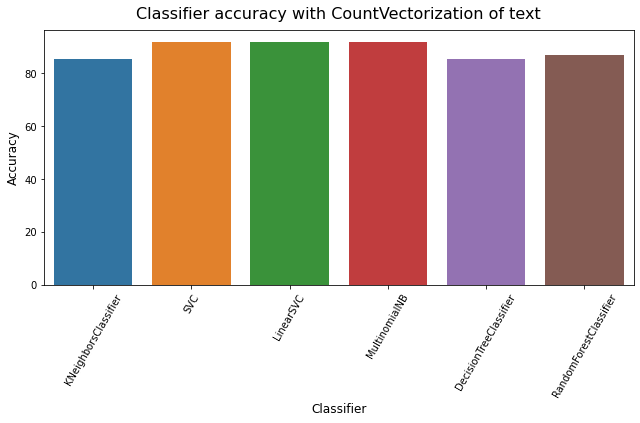

In [43]:
plt.figure(figsize = (9, 6))
ax = sns.barplot(x = 'Classifier', y = 'Accuracy', data = log)
plt.xticks(rotation = 60)
plt.xlabel('Classifier', size = 12)
plt.ylabel('Accuracy', size = 12)
plt.title('Classifier accuracy with CountVectorization of text', size = 16, y = 1.02)
plt.tight_layout()
plt.show()

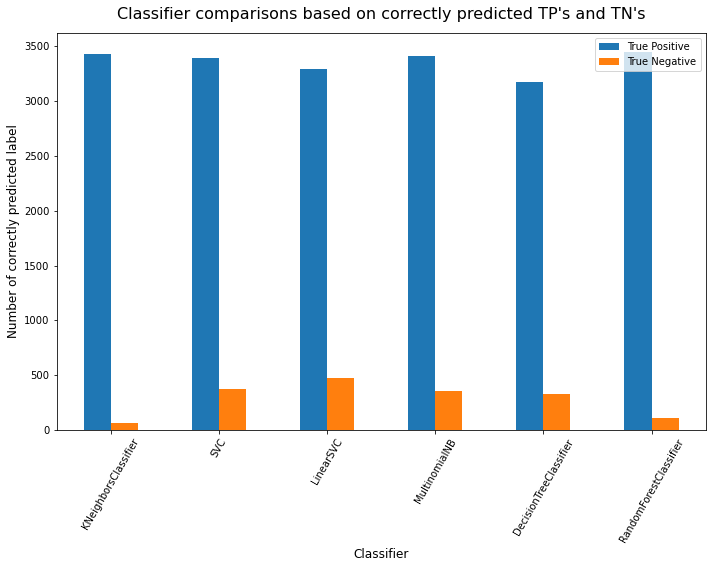

In [44]:
log.plot(x = 'Classifier', y = ['True Positive', 'True Negative'], kind = 'bar', figsize = (10, 8))
plt.xticks(rotation = 60)
plt.xlabel('Classifier', size = 12)
plt.ylabel('Number of correctly predicted label', size = 12)
plt.title("Classifier comparisons based on correctly predicted TP's and TN's", size = 16, y = 1.02)
plt.tight_layout()
plt.show()

### TF-IDF Vectorization of text (corpus)

#### We can further vectorize the text data using TF-IDF (Term frequency Inverse Document Frequency). TF-IDF computes the "relative frequency" that a word appears in a document compared to its frequency across all documents. The IDF involves the downscale weights for words that occur in many documents in the corpus and are therefore less information than those that occur only in a smaller portion of the corpus. 

In [45]:
tfidf_vec = TfidfVectorizer(max_df = 0.98)
tfidf_count_train = tfidf_vec.fit_transform(X_train.values)
tfidf_count_val = tfidf_vec.transform(X_val.values)

In [46]:
tfidf_count_val.shape

(4098, 59249)

### Training of classifier models and evaluation

KNeighborsClassifier


****Accuracy****
Accuracy: 0.8726207906295754

****Confusion matrix****


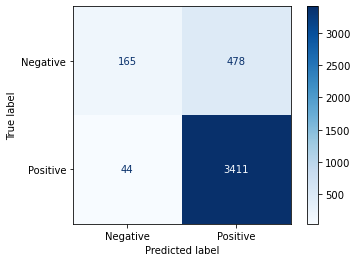

SVC


****Accuracy****
Accuracy: 0.9241093216203026

****Confusion matrix****


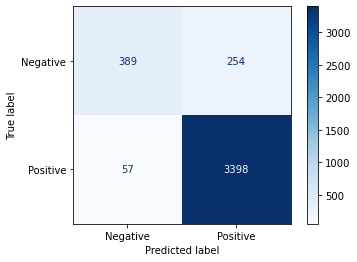

LinearSVC


****Accuracy****
Accuracy: 0.9285017081503172

****Confusion matrix****


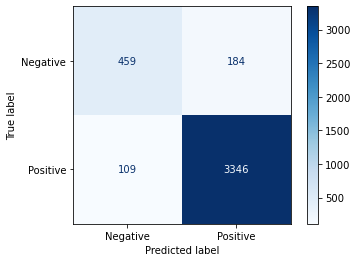

MultinomialNB


****Accuracy****
Accuracy: 0.8430941922889215

****Confusion matrix****


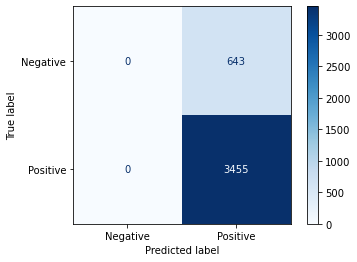

DecisionTreeClassifier


****Accuracy****
Accuracy: 0.8550512445095169

****Confusion matrix****


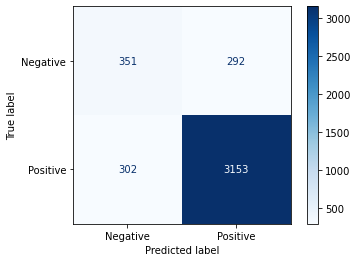

RandomForestClassifier


****Accuracy****
Accuracy: 0.8650561249389946

****Confusion matrix****


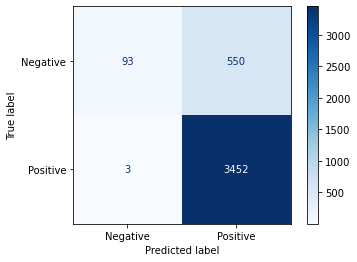

In [47]:
random_state = 1
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", random_state = random_state),
    LinearSVC(random_state = random_state),
    MultinomialNB(),
    DecisionTreeClassifier(random_state = random_state),
    RandomForestClassifier(random_state = random_state),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'True Positive', 'True Negative']
log = pd.DataFrame(columns=log_cols)

i = 0
for clf in classifiers:
    i += 1
    clf.fit(tfidf_count_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)
    print('\n')
    print('****Accuracy****')
    y_pred_tfidf = clf.predict(tfidf_count_val)
    acc = accuracy_score(y_val, y_pred_tfidf)
    tn = confusion_matrix(y_pred_tfidf, y_val)[0, 0]
    tp = confusion_matrix(y_pred_tfidf, y_val)[1, 1]
    print("Accuracy: {}\n".format(acc))
    print('****Confusion matrix****')
    ax = plot_confusion_matrix(clf, tfidf_count_val, y_val, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
    plt.show()
    log_entry = pd.DataFrame([[name, acc*100, tp, tn]], columns=log_cols, index = [i]) #appending a new row
    log = log.append(log_entry)
print("="*30)

In [48]:
log

,Classifier,Accuracy,True Positive,True Negative
1,KNeighborsClassifier,87.262079,3411,165
2,SVC,92.410932,3398,389
3,LinearSVC,92.850171,3346,459
4,MultinomialNB,84.309419,3455,0
5,DecisionTreeClassifier,85.505124,3153,351
6,RandomForestClassifier,86.505612,3452,93


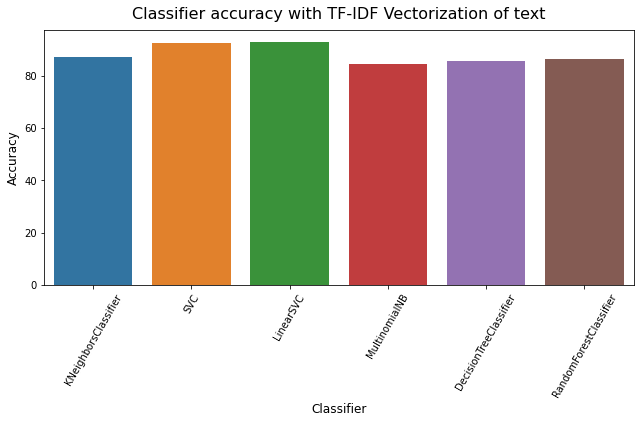

In [49]:
plt.figure(figsize = (9, 6))
ax = sns.barplot(x = 'Classifier', y = 'Accuracy', data = log)
plt.xticks(rotation = 60)
plt.xlabel('Classifier', size = 12)
plt.ylabel('Accuracy', size = 12)
plt.title('Classifier accuracy with TF-IDF Vectorization of text', size = 16, y = 1.02)
plt.tight_layout()
plt.show()

#### Following TF-IDF vectorization of text, we see an improvement in maximum accuracy with LinearSVC leading the way (92.8%) 

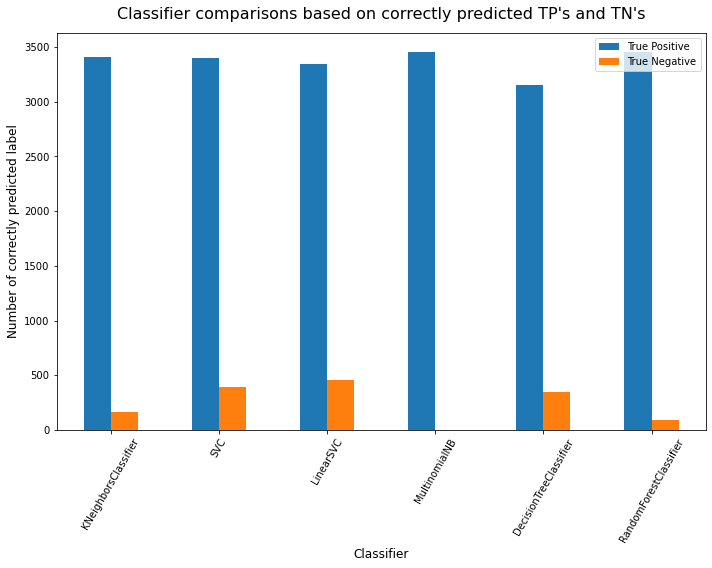

In [50]:
log.plot(x = 'Classifier', y = ['True Positive', 'True Negative'], kind = 'bar', figsize = (10, 8))
plt.xticks(rotation = 60)
plt.xlabel('Classifier', size = 12)
plt.ylabel('Number of correctly predicted label', size = 12)
plt.title("Classifier comparisons based on correctly predicted TP's and TN's", size = 16, y = 1.02)
plt.tight_layout()
plt.show()

#### From the figure, linearSVC provides a more balanced prediction with true positive and negative label. 

#### Can the classifier improve with further pre-processing step such as text lemmatization?

### Further text preprocessing involving lemmatization

#### Lemmatization involves the reduction of inflected words by properly ensuring that the root word belongs to the language. In lemmatization, root word is called **lemma**. A lemma is the canonical form, dictionary form, or citation form of a set of words. For example, run, running, ran are all forms of the word run, therefore run is the lemma of all these words.  

In [51]:
#Instantiates Class WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

#function to lemmatize clean and tokenized text 
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [52]:
#lemmatize X_train
lemma_X_train = X_train.apply(lambda x: lemmatize_words(x))

In [53]:
#lemmatize X_val
lemma_X_val = X_val.apply(lambda x: lemmatize_words(x))

In [54]:
tfidf_vec = TfidfVectorizer(max_df = 0.98)
lemma_tfidf_count_train = tfidf_vec.fit_transform(lemma_X_train.values)
lemma_tfidf_count_val = tfidf_vec.transform(lemma_X_val.values)

In [55]:
print("The number of feature reduced from {} to {} following lemmatization".format(tfidf_count_train.shape[1], lemma_tfidf_count_train.shape[1]))

The number of feature reduced from 59249 to 55799 following lemmatization


### Will text lemmatization improve training accuracy and prediction of correct class label?

KNeighborsClassifier


****Accuracy****
Accuracy: 0.8718887262079063

****Confusion matrix****


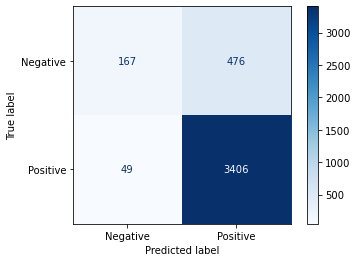

SVC


****Accuracy****
Accuracy: 0.924597364568082

****Confusion matrix****


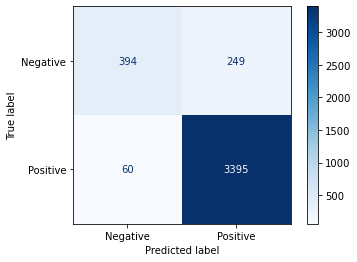

LinearSVC


****Accuracy****
Accuracy: 0.9285017081503172

****Confusion matrix****


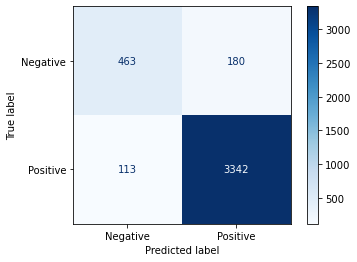

MultinomialNB


****Accuracy****
Accuracy: 0.8430941922889215

****Confusion matrix****


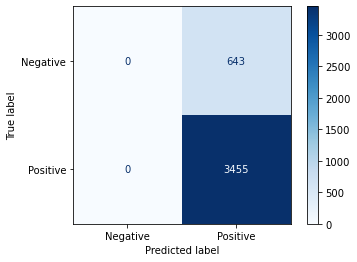

DecisionTreeClassifier


****Accuracy****
Accuracy: 0.8616398243045388

****Confusion matrix****


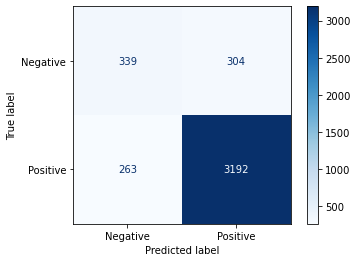

RandomForestClassifier


****Accuracy****
Accuracy: 0.8701805758906784

****Confusion matrix****


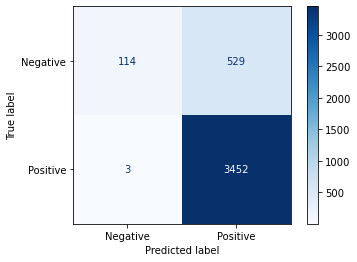

In [56]:
random_state = 1
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", random_state = random_state),
    LinearSVC(random_state = random_state),
    MultinomialNB(),
    DecisionTreeClassifier(random_state = random_state),
    RandomForestClassifier(random_state = random_state),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'True Positive', 'True Negative']
log3 = pd.DataFrame(columns=log_cols)

i = 0
for clf in classifiers:
    i += 1
    clf.fit(lemma_tfidf_count_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)
    print('\n')
    print('****Accuracy****')
    y_pred_tfidf_lemma = clf.predict(lemma_tfidf_count_val)
    acc = accuracy_score(y_val, y_pred_tfidf_lemma)
    tn = confusion_matrix(y_pred_tfidf_lemma, y_val)[0, 0]
    tp = confusion_matrix(y_pred_tfidf_lemma, y_val)[1, 1]
    print("Accuracy: {}\n".format(acc))
    print('****Confusion matrix****')
    ax = plot_confusion_matrix(clf, lemma_tfidf_count_val, y_val, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
    plt.show()
    log_entry = pd.DataFrame([[name, acc*100, tp, tn]], columns=log_cols, index = [i]) #appending a new row
    log3 = log3.append(log_entry)
print("="*30)

In [57]:
log3

,Classifier,Accuracy,True Positive,True Negative
1,KNeighborsClassifier,87.188873,3406,167
2,SVC,92.459736,3395,394
3,LinearSVC,92.850171,3342,463
4,MultinomialNB,84.309419,3455,0
5,DecisionTreeClassifier,86.163982,3192,339
6,RandomForestClassifier,87.018058,3452,114


#### There was no significant improvement in label prediction following lemmatization

### Vectorizing text data with N-Grams

#### Another pre-processing step that may help improve prediction is the splitting text into N-grams. N-grams are simply all combination of adjacent words of length n that we can find in our source text. 

In [58]:
tfidf_vec = TfidfVectorizer(max_df = 0.98, ngram_range=(1, 2))
lemma_tfidf_count_train = tfidf_vec.fit_transform(lemma_X_train.values)
lemma_tfidf_count_val = tfidf_vec.transform(lemma_X_val.values)

In [59]:
print("The total number of features is now {} since the features consist of both unigram and bigram".format(lemma_tfidf_count_val.shape[1]))

The total number of features is now 680089 since the features consist of both unigram and bigram


### Will the splitting of text into unigram and bigram improve training accuracy and the prediction of correct class label?

KNeighborsClassifier


****Accuracy****
Accuracy: 0.8755490483162518

****Confusion matrix****


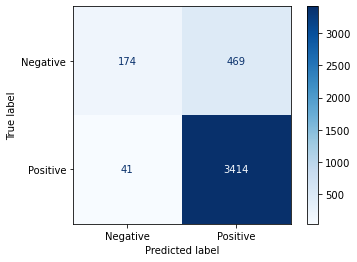

SVC


****Accuracy****
Accuracy: 0.9111761835041484

****Confusion matrix****


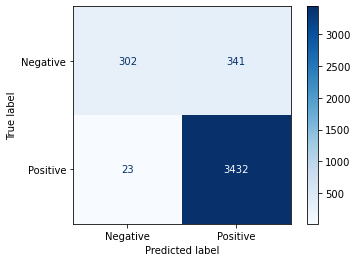

LinearSVC


****Accuracy****
Accuracy: 0.9316739873108834

****Confusion matrix****


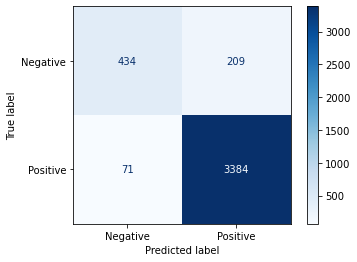

MultinomialNB


****Accuracy****
Accuracy: 0.8430941922889215

****Confusion matrix****


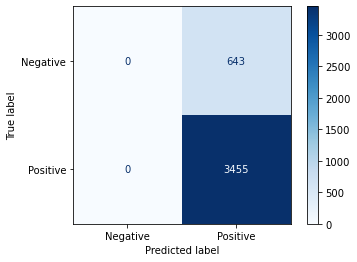

DecisionTreeClassifier


****Accuracy****
Accuracy: 0.8545632015617375

****Confusion matrix****


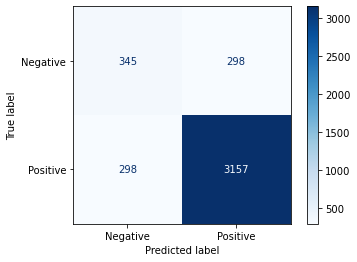

RandomForestClassifier


****Accuracy****
Accuracy: 0.8570034163006345

****Confusion matrix****


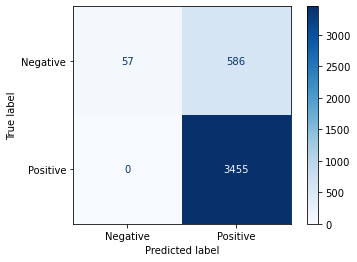

In [60]:
random_state = 1
classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", random_state = random_state),
    LinearSVC(random_state = random_state),
    MultinomialNB(),
    DecisionTreeClassifier(random_state = random_state),
    RandomForestClassifier(random_state = random_state),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'True Positive', 'True Negative']
log4 = pd.DataFrame(columns=log_cols)

i = 0
for clf in classifiers:
    i += 1
    clf.fit(lemma_tfidf_count_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)
    print('\n')
    print('****Accuracy****')
    y_pred_tfidf_lemma = clf.predict(lemma_tfidf_count_val)
    acc = accuracy_score(y_val, y_pred_tfidf_lemma)
    tn = confusion_matrix(y_pred_tfidf_lemma, y_val)[0, 0]
    tp = confusion_matrix(y_pred_tfidf_lemma, y_val)[1, 1]
    print("Accuracy: {}\n".format(acc))
    print('****Confusion matrix****')
    ax = plot_confusion_matrix(clf, lemma_tfidf_count_val, y_val, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
    plt.show()
    log_entry = pd.DataFrame([[name, acc*100, tp, tn]], columns=log_cols, index = [i]) #appending a new row
    log4 = log4.append(log_entry)
print("="*30)

In [61]:
log4

,Classifier,Accuracy,True Positive,True Negative
1,KNeighborsClassifier,87.554905,3414,174
2,SVC,91.117618,3432,302
3,LinearSVC,93.167399,3384,434
4,MultinomialNB,84.309419,3455,0
5,DecisionTreeClassifier,85.456320,3157,345
6,RandomForestClassifier,85.700342,3455,57


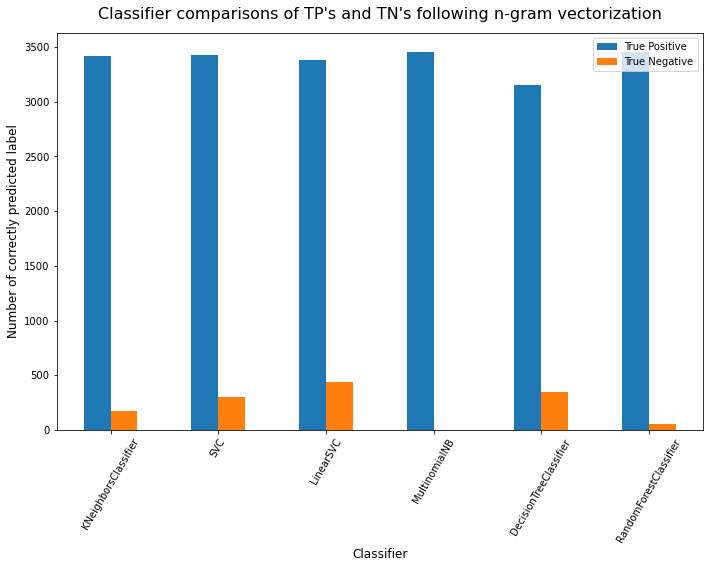

In [62]:
log4.plot(x = 'Classifier', y = ['True Positive', 'True Negative'], kind = 'bar', figsize = (10, 8))
plt.xticks(rotation = 60)
plt.xlabel('Classifier', size = 12)
plt.ylabel('Number of correctly predicted label', size = 12)
plt.title("Classifier comparisons of TP's and TN's following n-gram vectorization", size = 16, y = 1.02)
plt.tight_layout()
plt.show()

#### Following text vectorization with n-gram, only LinearSVC model improved with an accuracy of 93.16 %. As a result, I will focus on SVC model and tune its parameters using RandomSearchCV to even acheive a higher prediction 

### Parameter optimization with RandomSearchCV

In [63]:
param_dist = {'C': [0.1, 1, 10, 100, 1000],   
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf']} 

grid = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_jobs=-1, random_state = random_state, cv = 5)

grid.fit(lemma_tfidf_count_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'rbf']},
                   random_state=1)

In [64]:
y_val_grid = grid.best_estimator_.predict(lemma_tfidf_count_val)

In [65]:
print('The accuracy of the SVC model following parameter optimization is {}'.format(accuracy_score(y_val, y_val_grid)))

The accuracy of the SVC model following parameter optimization is 0.9346022449975598


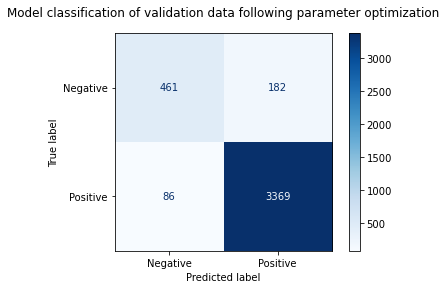

In [66]:
ax = plot_confusion_matrix(grid.best_estimator_, lemma_tfidf_count_val, y_val, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
plt.title('Model classification of validation data following parameter optimization', y = 1.05)
plt.show()

### Model prediction on Unseen data (Test data)

In [67]:
X_test

14004    loved hotel france albion wanted stay little h...
4448     loved hotel read reviews hotel nt quite sure e...
7328     spacious stayed 2 bdr 2 ba wsofa bed suite acc...
13085    fantastic experience husband decided spend nig...
588      great hotel paid fraction standard room price ...
                               ...                        
16564    paradise bali spirit hotel family stayed river...
6579     wonderful vacation barcelo bavaro caribe punta...
3976     thank goodness husband slept corridors smelled...
15065    avoid hotel bound spend 4 nights 3 weeks honey...
5013     loved hotel casci recently stayed hotel casci ...
Name: Review_tokenized_with_no_stop_words, Length: 4099, dtype: object

In [68]:
#lemmatize X_test first
lemma_X_test = X_test.apply(lambda x: lemmatize_words(x))

In [69]:
tfidf_vec

TfidfVectorizer(max_df=0.98, ngram_range=(1, 2))

In [70]:
#Transform lemmatized text to sparse matrix
lemma_tfidf_count_test = tfidf_vec.transform(lemma_X_test.values)

In [71]:
# model prediction
y_test_grid = grid.best_estimator_.predict(lemma_tfidf_count_test)

In [72]:
print('The accuracy of the SVC model on test (or unseen data) is {}'.format(accuracy_score(y_test, y_test_grid)))

The accuracy of the SVC model on test (or unseen data) is 0.9294949987801903


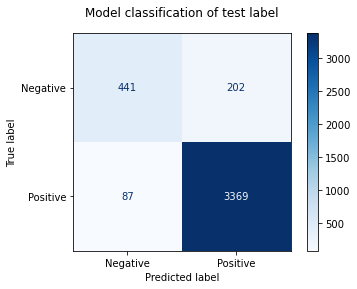

In [73]:
ax = plot_confusion_matrix(grid.best_estimator_, lemma_tfidf_count_test, y_test, display_labels=np.array(['Negative', 'Positive']), cmap =plt.cm.Blues)
plt.title('Model classification of test label', y = 1.05)
plt.show()

In [74]:
hotel_review_model_classfier = grid.best_estimator_

### Model test on made-up review.

In [75]:
positive_review = 'I had a really gud Experience. The hotel was cleaning, and they made sure everywhere was need and tidy before we got there. I was able to have a cold shower in a clean bathub. They made sure we got our breakfast on time with delicious appetizer'

In [76]:
negative_review = 'horrible customer service hotel. The toilet was dutty, the sheet pillows digusted me when I initially saw it. Not worth it'

In [77]:
def model_test(review):
    
    review = pd.Series(review, dtype=pd.StringDtype())
    text = review.apply(lambda x: clean_url(x))
    text = text.apply(lambda x: x.lower())
    text = text.apply(lambda x: x.translate(str.maketrans('', '', punctuation)))
    text = text.apply(lambda x: clean_contractions(x, contractions_dict))
    text = text.apply(lambda x: tokenize_text(x))
    text = text.apply(lambda x: remove_stopwords(x))
    lemma_text = text.apply(lambda x: lemmatize_words(x))
    lemma_tfidf_text = tfidf_vec.transform(lemma_text.values)
    label = hotel_review_model_classfier.predict(lemma_tfidf_text)
    print('Based on this review, the classifier predicts it as {}'.format(label[0]))

In [78]:
model_test(positive_review)

Based on this review, the classifier predicts it as Positive


In [79]:
model_test(negative_review)

Based on this review, the classifier predicts it as Negative


### Save hotel review classifier model

In [80]:
import pickle

file_name = 'hotel_classifier_model.sav'
pickle.dump(hotel_review_model_classfier, open(file_name, 'wb'))